# Homework 1 - Exercise 2 

In [3]:
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Create the graph

In [5]:
# Manual layout used for all the plots 
pos = {
    # Clique (right)
    "n1": (2.5, -0.5),
    "n2": (3.0, -0.5),
    "n3": (3.5, 0.0),
    "n4": (3.0, 0.5),
    "n5": (2.5, 0.5),
    "n6": (2.0, 0.0),
    "n15": (1.5, 0.5),

    # Path bridge
    "n7": (1.5, 0.0),
    "n8": (1.0, 0.0),

    # Left star around n9
    "n9": (0.5, 0.0),
    "n10": (0.5, 0.5),
    "n11": (0.25, 0.25),
    "n12": (0.0, 0.0),
    "n13": (0.25, -0.25),
    "n14": (0.5, -0.5),
}

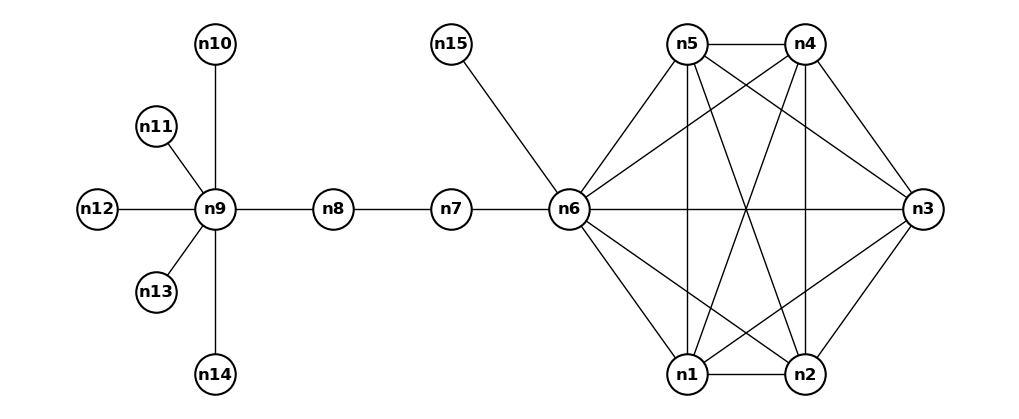

In [6]:
# Create the rigth part of the graph as a complete graph
complete_label = [f"n{i}" for i in range(1, 7)]
complete = nx.complete_graph(complete_label)

#Create the left part of the graph as a star graph
star = nx.star_graph(5)
star_mapping = {0: "n9"} | {i: f"n{9+i}" for i in range(1, 6)}
star = nx.relabel_nodes(star, star_mapping)

#Add remaining nodes 
G = nx.Graph()
#G.add_nodes_from(complete)
G.update(complete) 
G.update(star)

G.add_nodes_from(["n8", "n7", "n15"])
G.add_edges_from([("n8", "n9"), ("n7", "n8"), ("n6", "n7"), ("n6", "n15")])

plt.figure(figsize=(10, 4))
nx.draw(
    G, pos,
    with_labels=True,
    node_color="white",
    edgecolors="black",
    font_weight="bold",
    node_size=850,
    linewidths=1.5
)
plt.axis("off")
plt.show()

In [7]:
# Compute matrices of the graph
W = nx.adjacency_matrix(G)
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W
N = G.number_of_nodes()

## Request A

**R:** Compute the Katz centrality, with $\beta = 0.15$ and uniform intrinsic centrality $\mu$.

We compute Katz centrality by iterative method, considering the following dynamics:

$$
\begin{cases} 
z(t+1) = \frac{(1-\beta)}{\lambda_W}W'z(t) + \beta \mu  \\
z(0) = z_0.
\end{cases}
$$

In [10]:
def iterative_katz_centrality(W, beta, mu, z0, tol=1e-5): 
    z_old = z0 

    #Compute the largest eigenvalue of W
    eigenvalues, _ = np.linalg.eig(W)

    # Find index of dominant eigenvalue
    lamndaW = max(eigenvalues.real)
    
    while True: 
        z_new = (1-beta)/lamndaW * W.T @ z_old + beta * mu 
        if np.linalg.norm(z_new - z_old) < tol: 
            break
        z_old = z_new 

    zk = z_new 
    # Normalize the centrality
    zk = zk / sum(zk) 
    
    return zk

In [11]:
def plot_centrality(G, pos, centrality_values, ax=None, title="", vmin=None, vmax=None): 
    """Draws graph centrality values with fixed color normalization."""
    if ax is None:
        ax = plt.gca()
    nodes = list(G.nodes())
    
    nx.draw(
        G, pos, ax=ax,
        with_labels=True,
        # node size is proportional to centrality value
        node_size = [d*10000 for d in centrality_values], 
        # node's color reflects centrality values (higher = darker color)
        node_color=centrality_values,
        edgecolors="black",
        font_size=8,
        # node's colors are on the red scale
        cmap=plt.cm.Reds,
        vmin=vmin, 
        vmax=vmax, 
    ) 

    ax.set_title(title, fontsize=11)
    ax.axis("off")



=== Katz Centrality (β = 0.15) ===
Node Katz Centrality
  n6        0.130079
  n1        0.118138
  n2        0.118138
  n3        0.118138
  n4        0.118138
  n5        0.118138
  n7        0.044247
  n9        0.042813
 n15        0.038930
  n8        0.031722
 n10        0.024305
 n11        0.024305
 n12        0.024305
 n13        0.024305
 n14        0.024305


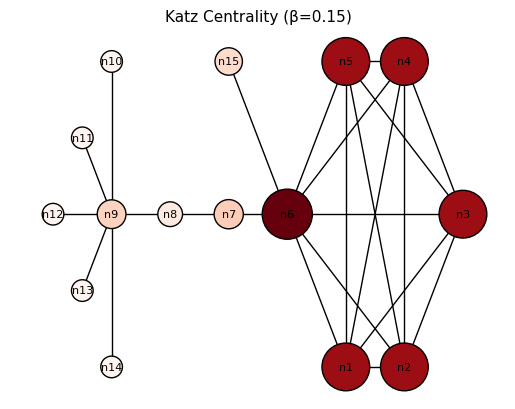

In [12]:
#Parameters and Initial Conditions 
beta = 0.15
z0 = np.ones((N,1))/N
mu = np.ones((N,1))/N

#Compute Katz centrality 
zk = iterative_katz_centrality(W, beta, mu, z0)
zk = np.array(zk).flatten()
zk_min, zk_max = zk.min(), zk.max()

df_katz = pd.DataFrame({"Node": list(G.nodes()), "Katz Centrality": zk})
df_katz = df_katz.sort_values(by="Katz Centrality", ascending=False).reset_index(drop=True)
print("\n=== Katz Centrality (β = 0.15) ===")
print(df_katz.to_string(index=False, formatters={"Katz Centrality": "{:.6f}".format}))

plot_centrality(G, pos, zk, title="Katz Centrality (β=0.15)", vmin=zk_min, vmax=zk_max)
plt.show() 

## Request B 
**R:** Write a distributed algorithm for the computation of Page-rank centrality, with $\beta = 0.15$ and
uniform intrinsic centrality $\mu$.

Page-rank centrality is the Bonacich centrality with $\mu=\mathbf{1}$ and $\beta=0.15$.
We compute Page-rank centrality by distributed iterative method, considering the following dynamics:
$$
\begin{cases} 
z(t+1) = (1-\beta)P'z(t) + \beta \mu  \\
z(0) = z_0
\end{cases}
$$

The method is **distributed**, i.e., the operations at single node levels do not require a complete knowledge of the network. Each node $i$ updates its state $z_i(t+1)$ by using only local information, i.e., the i-th row of $W$ and the state $z_j(t)$ of nodes $j$ that are adjacent to $j$.

In [14]:
def iterative_page_rank_centrality(P, beta, mu, z0, tol=1e-5): 
    # run the dynamics
    z_old = z0

    while True:
        z_new = P.T @ z_old * (1-beta) + beta * mu
        if np.linalg.norm(z_new-z_old) < tol:
            break
        z_old=z_new

    zpr_distr = z_new

    # normalize the centrality
    zpr_distr = zpr_distr / sum(zpr_distr)

    return zpr_distr

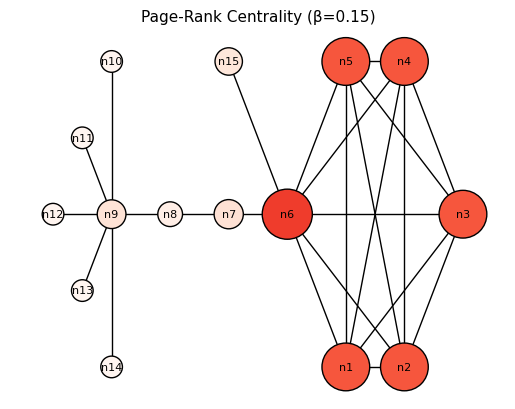

Normalization (PageRank): 1.000000
Normalization (NetworkX):      1.000000

Comparison of PageRank centralities (β = 0.15):
Node PageRank NetworkX PageRank Abs Diff
  n9 0.194041          0.194042 1.01e-06
  n6 0.114451          0.114451 6.96e-08
  n1 0.074680          0.074680 3.40e-08
  n2 0.074680          0.074680 3.40e-08
  n3 0.074680          0.074680 3.40e-08
  n4 0.074680          0.074680 3.40e-08
  n5 0.074680          0.074680 3.40e-08
  n8 0.058150          0.058150 2.77e-07
  n7 0.048611          0.048611 1.45e-07
 n10 0.037490          0.037490 1.99e-07
 n11 0.037490          0.037490 1.99e-07
 n12 0.037490          0.037490 1.99e-07
 n13 0.037490          0.037490 1.99e-07
 n14 0.037490          0.037490 1.99e-07
 n15 0.023898          0.023898 1.90e-08


In [15]:
#Parameters and Initial Conditions 
beta = 0.15
z0 = np.ones((N,1))/N
mu = np.ones((N,1))/N

# Compute PageRank centrality
zpr = iterative_page_rank_centrality(P, beta, mu, z0)
zpr = np.array(zpr).flatten()
zpr_min, zpr_max = zpr.min(), zpr.max()
plot_centrality(G, pos, zk, title="Page-Rank Centrality (β=0.15)", vmin=zpr_min, vmax=zpr_max)
plt.show() 

# Compute PageRank using NetworkX (as reference)
nx_pr_dict = nx.pagerank(G, alpha=(1 - beta))
nx_pr = np.array([nx_pr_dict[n] for n in G.nodes()])

# Normalization check
print(f"Normalization (PageRank): {zpr.sum():.6f}")
print(f"Normalization (NetworkX):      {nx_pr.sum():.6f}\n")

# Create combined comparison table
df_compare = pd.DataFrame({
    "Node": list(G.nodes()),
    "PageRank": zpr,
    "NetworkX PageRank": nx_pr,
})

# Add absolute difference column
df_compare["Abs Diff"] = abs(df_compare["PageRank"] - df_compare["NetworkX PageRank"])

# Sort by NetworkX PageRank
df_compare = df_compare.sort_values(by="NetworkX PageRank", ascending=False).reset_index(drop=True)

# Print in nice tabular form
print("Comparison of PageRank centralities (β = 0.15):")
print(df_compare.to_string(index=False, formatters={
    "PageRank": "{:.6f}".format,
    "NetworkX PageRank": "{:.6f}".format,
    "Abs Diff": "{:.2e}".format
}))

## Request D
Compute the Page-Rank centrality with uniform intrinsic centrality $\mu$ and for every
$\beta \in \{0,\frac14,\frac12,\frac34, 1\}$

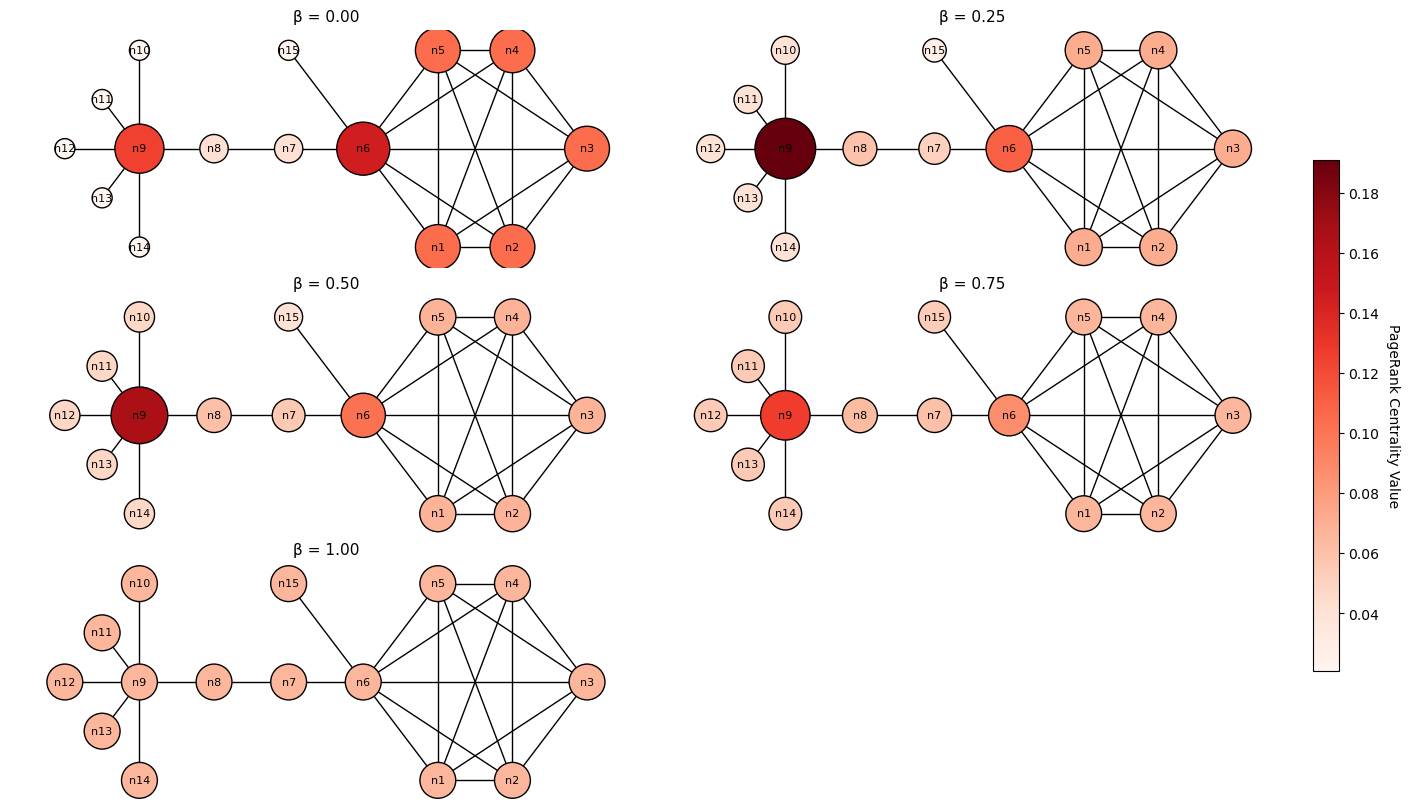


=== Summary of PageRank values for different β ===
Node   β=0.00   β=0.25   β=0.50   β=0.75   β=1.00
  n9 0.124996 0.191113 0.166695 0.126977 0.066667
  n6 0.145834 0.110605 0.101404 0.087507 0.066667
  n1 0.104167 0.071293 0.067627 0.066407 0.066667
  n2 0.104167 0.071293 0.067627 0.066407 0.066667
  n3 0.104167 0.071293 0.067627 0.066407 0.066667
  n4 0.104167 0.071293 0.067627 0.066407 0.066667
  n5 0.104167 0.071293 0.067627 0.066407 0.066667
  n8 0.041668 0.059637 0.061193 0.062915 0.066667
  n7 0.041666 0.050880 0.055875 0.060989 0.066667
 n10 0.020834 0.040557 0.047224 0.055291 0.066667
 n11 0.020834 0.040557 0.047224 0.055291 0.066667
 n12 0.020834 0.040557 0.047224 0.055291 0.066667
 n13 0.020834 0.040557 0.047224 0.055291 0.066667
 n14 0.020834 0.040557 0.047224 0.055291 0.066667
 n15 0.020833 0.028517 0.040576 0.053125 0.066667


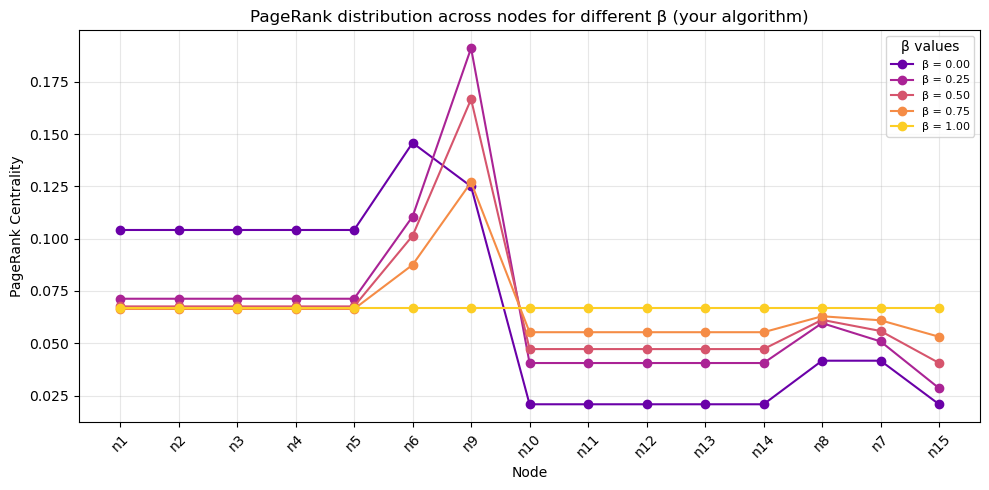

In [17]:
betas = [0.0, 0.25, 0.5, 0.75, 1.0]
z0 = np.ones((N, 1)) / N
mu = np.ones((N, 1)) / N

results = {}

for beta in betas:
    zpr = iterative_page_rank_centrality(P, beta, mu, z0)
    results[beta] = np.array(zpr).flatten()

# Global min/max for consistent color scale
global_min = min(z.min() for z in results.values())
global_max = max(z.max() for z in results.values())

fig, axes = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)
axes = axes.flatten()

for i, beta in enumerate(betas):
    plot_centrality(G, pos, results[beta],
                    ax=axes[i],
                    title=f"β = {beta:.2f}",
                    vmin=global_min,
                    vmax=global_max)

# Hide any unused subplot
for j in range(len(betas), len(axes)):
    axes[j].axis("off")

sm = mpl.cm.ScalarMappable(cmap=plt.cm.Reds, norm=mpl.colors.Normalize(vmin=global_min, vmax=global_max))
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("PageRank Centrality Value", rotation=270, labelpad=15)

plt.show()

# ---- Summary table ----
summary_df = pd.DataFrame({"Node": list(G.nodes())})
for beta in betas:
    summary_df[f"β={beta:.2f}"] = results[beta]

summary_df = summary_df.sort_values(by="β=0.50", ascending=False).reset_index(drop=True)

print("\n=== Summary of PageRank values for different β ===")
print(summary_df.to_string(index=False, formatters={col: "{:.6f}".format for col in summary_df.columns if col != "Node"}))

node_labels = list(G.nodes())
x = np.arange(len(node_labels))
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(betas)))

plt.figure(figsize=(10, 5))

# Plot PageRank distributions for each beta
for i, beta in enumerate(betas):
    pr_values = results[beta]
    plt.plot(x, pr_values, color=colors[i], marker='o', label=f'β = {beta:.2f}')

plt.xticks(x, node_labels, rotation=45)
plt.xlabel("Node")
plt.ylabel("PageRank Centrality")
plt.title("PageRank distribution across nodes for different β (your algorithm)")
plt.legend(title="β values", fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()